In questa seconda parte ci occuperemo di effettuare un'analisi descrittiva grafica più approfondita. Inoltre effettueremo feature selection sulle nostre variabili predittive.

In [31]:
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Percorso del file CSV (sostituisci con il tuo percorso corretto)
file_path_train = '/content/drive/MyDrive/Recruiting/DataChallenge/processed_df_train_1stpart.csv'

# Lettura del file CSV con delimitatore `;` e pulizia
df_train = pd.read_csv(file_path_train,header=0, engine='python')

# Visualizza le prime righe del dataset per conferma
print("Prime 5 righe del dataset di train:")
display(df_train.head())

Prime 5 righe del dataset di train:


,PAID,MONTH,N_SUBSCRIPTIONS,PRICE,PHONE_NUMBER,DAYS_FROM_PROMO,BOOKS_PAID,N_TRANSACTIONS,N_ITEMS,MAIL,...,PAYMENT_TYPE_Cash,PAYMENT_TYPE_Coupon,FAV_GENRE_Shojo,FAV_GENRE_Shonen,AGE_<10–14,AGE_15–21,AGE_22–30+,PROP_CONBINI_Alto,PROP_CONBINI_Basso,PROP_CONBINI_Medio
0,1.0,7,1,10.99,0,1,8,3,2,0,...,False,False,False,True,False,True,False,False,True,False
1,1.0,9,1,13.30,0,20,5,2,4,0,...,True,False,False,True,False,True,False,False,False,True
2,1.0,5,2,18.79,0,6,3,1,3,0,...,False,False,False,True,False,False,True,False,True,False
3,1.0,4,0,7.96,0,1,1,1,2,0,...,False,False,False,True,False,True,False,False,True,False
4,1.0,6,0,12.00,0,1,3,1,3,0,...,True,False,False,True,False,True,False,True,False,False


In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16842 entries, 0 to 16841
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PAID                       16842 non-null  float64
 1   MONTH                      16842 non-null  int64  
 2   N_SUBSCRIPTIONS            16842 non-null  int64  
 3   PRICE                      16842 non-null  float64
 4   PHONE_NUMBER               16842 non-null  int64  
 5   DAYS_FROM_PROMO            16842 non-null  int64  
 6   BOOKS_PAID                 16842 non-null  int64  
 7   N_TRANSACTIONS             16842 non-null  int64  
 8   N_ITEMS                    16842 non-null  int64  
 9   MAIL                       16842 non-null  int64  
 10  SUBSCR_CANC                16842 non-null  int64  
 11  MARGIN                     16842 non-null  float64
 12  DAYS_BETWEEN_TRANSACTIONS  16842 non-null  int64  
 13  POINT_OF_SALE_BO           16842 non-null  boo

# Analisi descrittiva delle variabili continue

Analizzo gli istogrammi delle varibili PHONE_NUMBER e MAIL rispetto alla variabile PAID

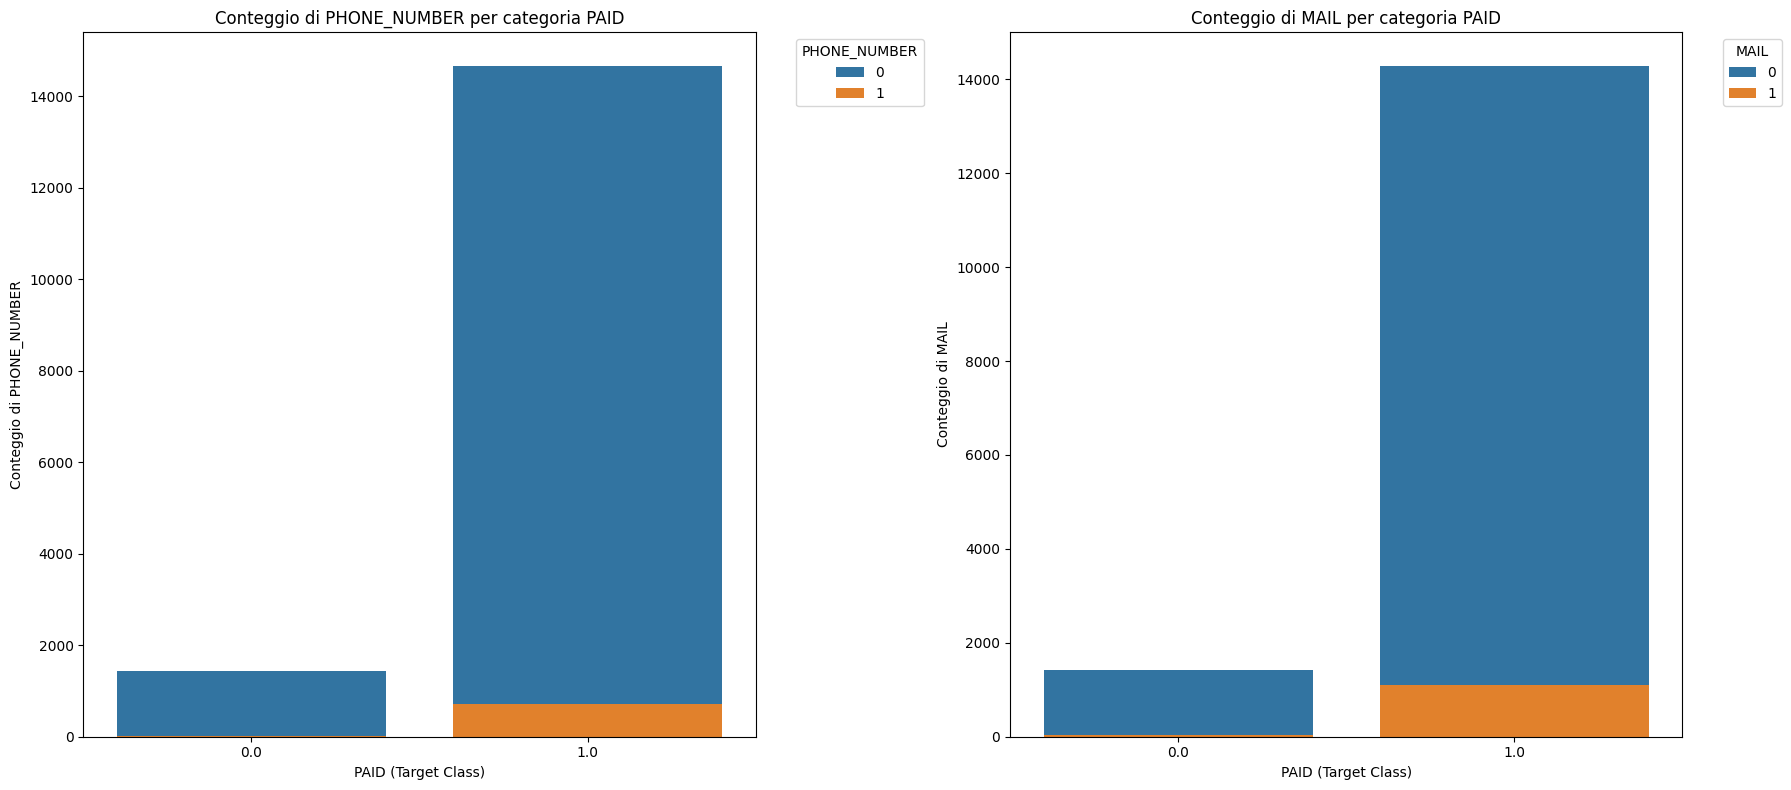

In [4]:
counts_phone = df_train.groupby(['PHONE_NUMBER', 'PAID']).size().reset_index(name='Counts')

counts_mail = df_train.groupby(['MAIL', 'PAID']).size().reset_index(name='Counts')

plt.figure(figsize=(18, 8))

plt.subplot(1, 2, 1)
sns.barplot(data=counts_phone, x='PAID', y='Counts', hue='PHONE_NUMBER', dodge=False)
plt.xlabel('PAID (Target Class)')
plt.ylabel('Conteggio di PHONE_NUMBER')
plt.title('Conteggio di PHONE_NUMBER per categoria PAID')
plt.legend(title='PHONE_NUMBER', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplot(1, 2, 2)
sns.barplot(data=counts_mail, x='PAID', y='Counts', hue='MAIL', dodge=False)
plt.xlabel('PAID (Target Class)')
plt.ylabel('Conteggio di MAIL')
plt.title('Conteggio di MAIL per categoria PAID')
plt.legend(title='MAIL', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [5]:
df_train['HAS_PHONE'] = df_train['PHONE_NUMBER'] == 1
df_train['HAS_EMAIL'] = df_train['MAIL'] == 1

total_obs = len(df_train)

categories = {
    "Ha fornito almeno un contatto e ha pagato": len(df_train[((df_train['HAS_PHONE'] == True) | (df_train['HAS_EMAIL'] == True)) & (df_train['PAID'] == 1)]),
    "Non ha fornito alcun contatto e ha pagato": len(df_train[(df_train['HAS_PHONE'] == False) & (df_train['HAS_EMAIL'] == False) & (df_train['PAID'] == 1)]),
    "Ha fornito almeno un contatto ma non ha pagato": len(df_train[((df_train['HAS_PHONE'] == True) | (df_train['HAS_EMAIL'] == True)) & (df_train['PAID'] == 0)]),
    "Non ha fornito alcun contatto e non ha pagato": len(df_train[(df_train['HAS_PHONE'] == False) & (df_train['HAS_EMAIL'] == False) & (df_train['PAID'] == 0)]),
}

percentages = {key: (value / total_obs) * 100 for key, value in categories.items()}

print("Conteggio delle categorie:")
for category, count in categories.items():
    print(f"{category}: {count} ({percentages[category]:.2f}%)")

Conteggio delle categorie:
Ha fornito almeno un contatto e ha pagato: 1153 (6.85%)
Non ha fornito alcun contatto e ha pagato: 14233 (84.51%)
Ha fornito almeno un contatto ma non ha pagato: 44 (0.26%)
Non ha fornito alcun contatto e non ha pagato: 1412 (8.38%)


Da questi dati e dai bar plot precedenti comprendiamo che che la maggior parte dei clienti del campione preferisce non fornire né l'email né il numero di telefono.

Tra quelli che non pagano la percentuale di quelli che non forniscono il contatto è più alta rispetto a quelli che lo forniscono come vediamo dall'analisi seguente:

Funzione per calcolare i conteggi e le percentuali rispetto a PAID:

In [6]:
def calculate_percentage(df, group_by_var):

    counts = df.groupby(['PAID', group_by_var]).size().reset_index(name='Counts')

    total_per_paid = counts.groupby('PAID')['Counts'].transform('sum')

    counts['Percentage'] = (counts['Counts'] / total_per_paid) * 100

    return counts

counts_phone_percentage = calculate_percentage(df_train, 'PHONE_NUMBER')

counts_mail_percentage = calculate_percentage(df_train, 'MAIL')


print("Percentuali di PHONE_NUMBER rispetto alla classe target PAID:")
print(counts_phone_percentage)

print("\nPercentuali di MAIL rispetto alla classe target PAID:")
print(counts_mail_percentage)


Percentuali di PHONE_NUMBER rispetto alla classe target PAID:
   PAID  PHONE_NUMBER  Counts  Percentage
0   0.0             0    1442   99.038462
1   0.0             1      14    0.961538
2   1.0             0   14665   95.313922
3   1.0             1     721    4.686078

Percentuali di MAIL rispetto alla classe target PAID:
   PAID  MAIL  Counts  Percentage
0   0.0     0    1413   97.046703
1   0.0     1      43    2.953297
2   1.0     0   14285   92.844144
3   1.0     1    1101    7.155856


Le percentuali tra le due categorie risultano complessivamente simili. Tuttavia, si osserva che nella categoria 1 la percentuale di fornitori di numero di telefono e di email è più alta rispetto alla categoria 0. Nonostante ciò, rimane significativo il numero di persone che, pur non fornendo il numero di telefono o l’email, procede comunque al pagamento.

Analizzo i boxplots delle variabili N_TRANSACTIONS e MARGIN

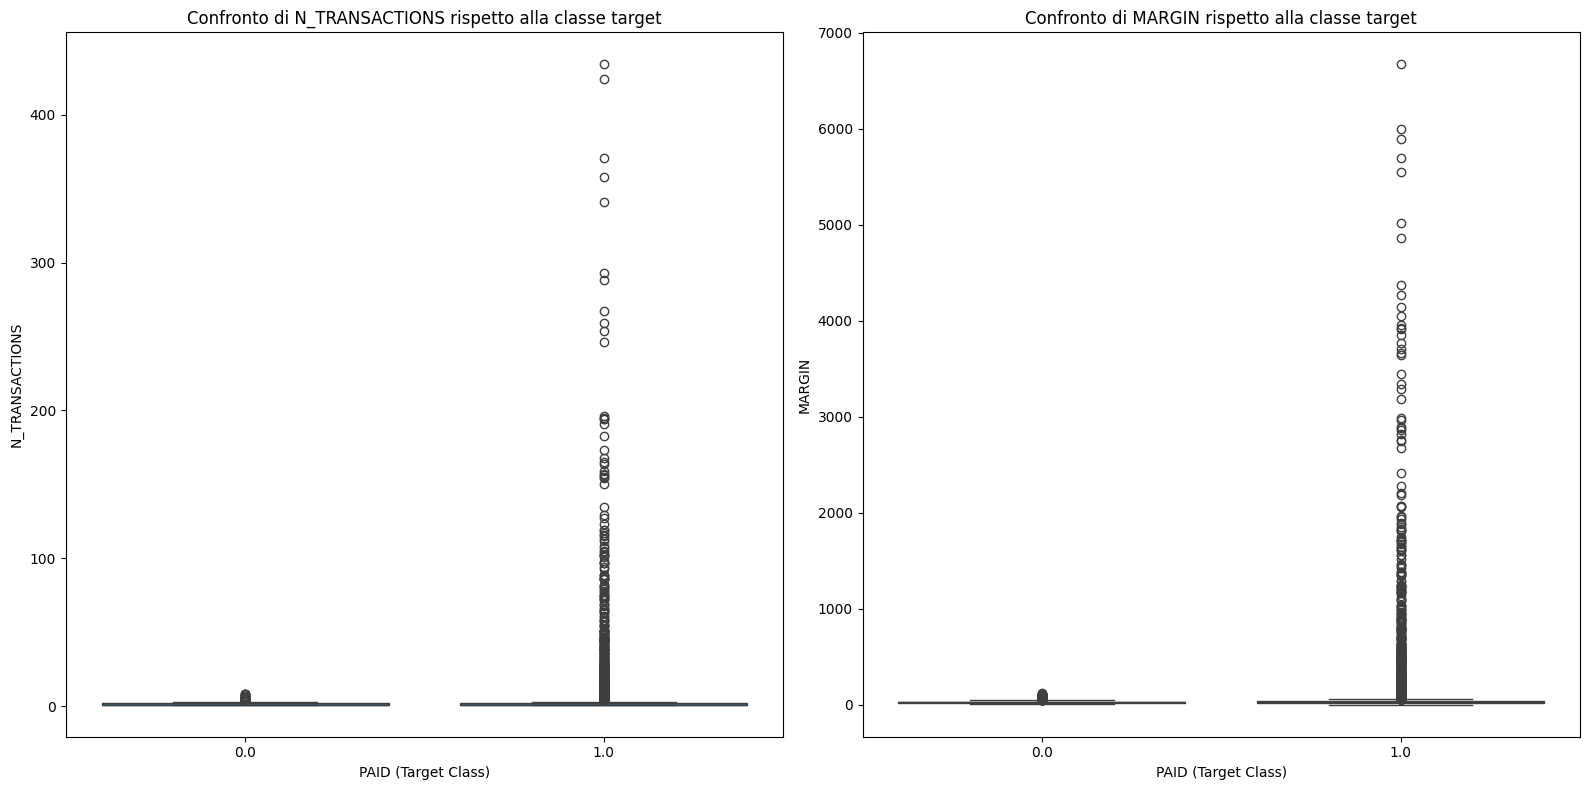

In [7]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
sns.boxplot(x='PAID', y='N_TRANSACTIONS', data=df_train)
plt.xlabel('PAID (Target Class)')
plt.ylabel('N_TRANSACTIONS')
plt.title('Confronto di N_TRANSACTIONS rispetto alla classe target')

plt.subplot(1, 2, 2)
sns.boxplot(x='PAID', y='MARGIN', data=df_train)
plt.xlabel('PAID (Target Class)')
plt.ylabel('MARGIN')
plt.title('Confronto di MARGIN rispetto alla classe target')

plt.tight_layout()
plt.show()

Come si può osservare, il numero di N_TRANSACTIONS nella classe positiva risulta significativamente più elevato rispetto a quello rilevato nella classe negativa. Analogamente, MARGIN aumenta di valore quando PAID assume valore 1, in linea con quanto ci aspetteremmo in uno scenario reale.

Guardiamo lo scatterplot relativo alla variabile N_TRANSACTIONS rispetto a DAYS_BETWEEN_TRANSACTIONS

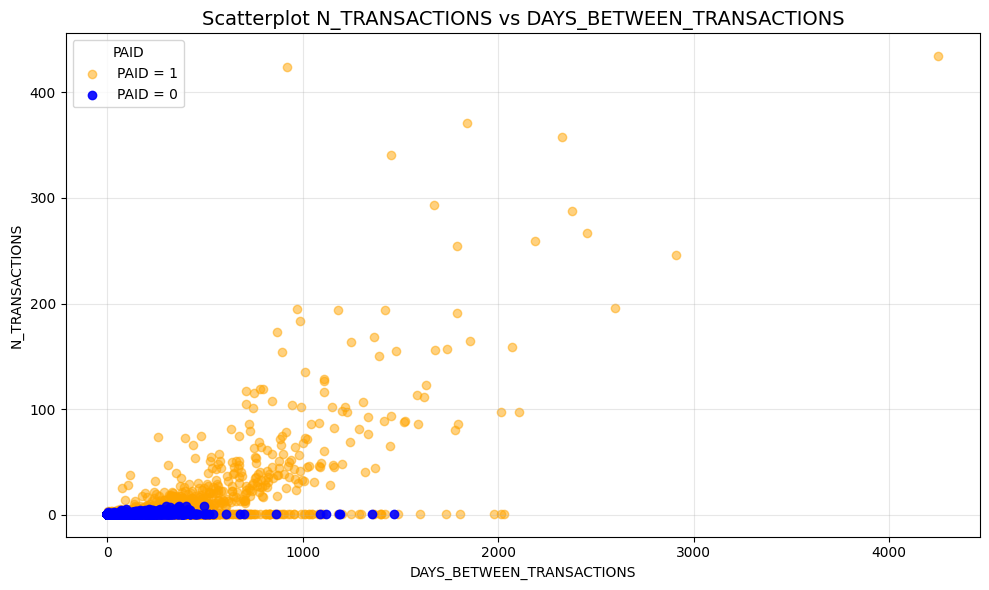

In [8]:
data_paid_0 = df_train[df_train['PAID'] == 0]
data_paid_1 = df_train[df_train['PAID'] == 1]

plt.figure(figsize=(10, 6))

plt.scatter(data_paid_1['DAYS_BETWEEN_TRANSACTIONS'], data_paid_1['N_TRANSACTIONS'],
            alpha=0.5, color='orange', label='PAID = 1', zorder=1)

plt.scatter(data_paid_0['DAYS_BETWEEN_TRANSACTIONS'], data_paid_0['N_TRANSACTIONS'],
            alpha=0.9, color='blue', label='PAID = 0', zorder=2)

plt.title('Scatterplot N_TRANSACTIONS vs DAYS_BETWEEN_TRANSACTIONS', fontsize=14)
plt.xlabel('DAYS_BETWEEN_TRANSACTIONS')
plt.ylabel('N_TRANSACTIONS')
plt.legend(title='PAID')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Notiamo:
- Come ci si potrebbe aspettare, all'aumentare dei giorni trascorsi dalla prima transazione (indicando quindi una relazione cliente-azienda di maggiore durata), cresce anche il numero complessivo di transazioni effettuate. Questo trend è particolarmente evidente tra i clienti con saldo YES, che possiamo considerare come i più fidelizzati.

- Al contrario, i clienti con saldo NO tendono a registrare un numero totale di transazioni più basso. Questo comportamento suggerisce che chi effettua poche transazioni ha una maggiore probabilità di non saldare il proprio debito.


la distribuzione di N_TRANSACTIONS risulta fortemente sbilanciata a sinistra come si vede dal grafico seguente:

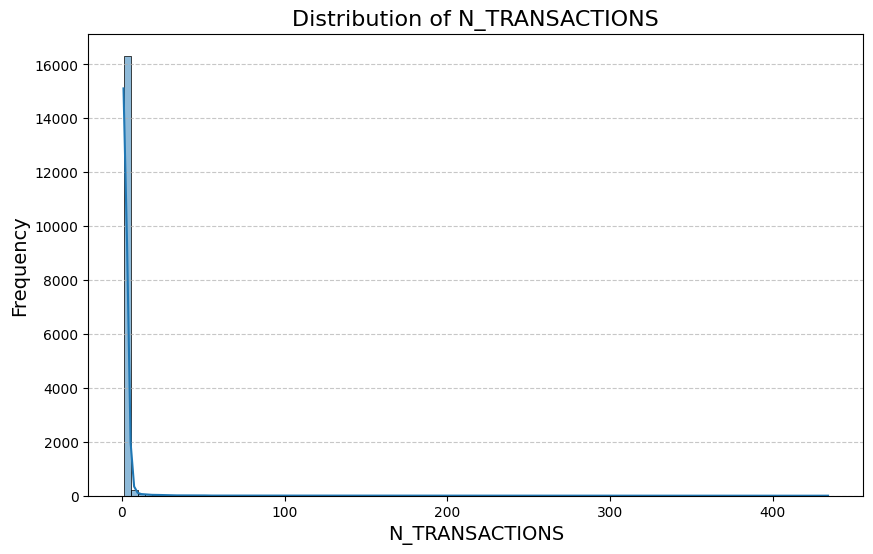

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['N_TRANSACTIONS'], kde=True, bins=100)
plt.title("Distribution of N_TRANSACTIONS", fontsize=16)
plt.xlabel("N_TRANSACTIONS", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Scatterplot N_TRANSACTIONS vs BOOKS_PAID

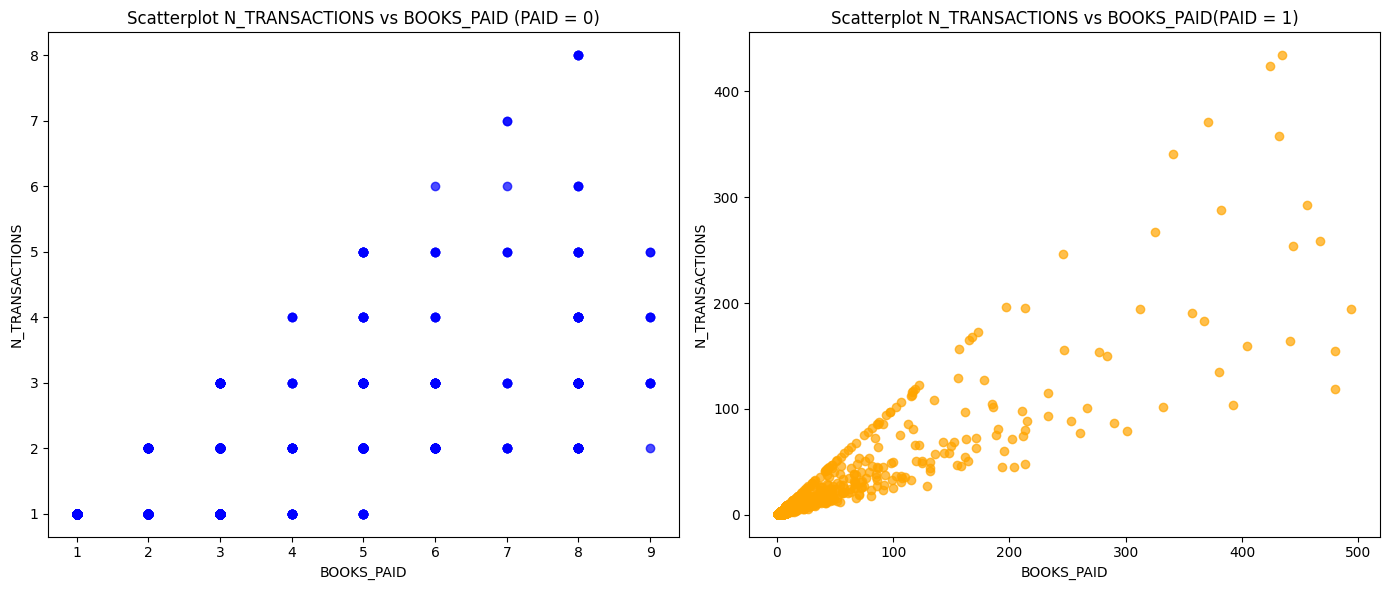

In [10]:
data_paid_0 = df_train[df_train['PAID'] == 0]
data_paid_1 = df_train[df_train['PAID'] == 1]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(data_paid_0['BOOKS_PAID'], data_paid_0['N_TRANSACTIONS'], alpha=0.7, color='blue')
plt.title('Scatterplot N_TRANSACTIONS vs BOOKS_PAID (PAID = 0)')
plt.xlabel('BOOKS_PAID')
plt.ylabel('N_TRANSACTIONS')

plt.subplot(1, 2, 2)
plt.scatter(data_paid_1['BOOKS_PAID'], data_paid_1['N_TRANSACTIONS'], alpha=0.7, color='orange')
plt.title('Scatterplot N_TRANSACTIONS vs BOOKS_PAID(PAID = 1)')
plt.xlabel('BOOKS_PAID')
plt.ylabel('N_TRANSACTIONS')

plt.tight_layout()
plt.show()

la relazione tra N_TRANSACTIONS e la variabile PAID sembrerebbe lineare e tuttavia non si può escludere l'ipotesi di eteroschedasticità. Inoltre, all'aumentare di BOOKS_PAID aumenta anche N_TRANSACTIONS e aumnet anche il numero di clienti papartenenti alla categoria PAID=1. I clienti che hanno acquistato meno libri, hanno compiuto meno transazioni e e appartengono alla categoria PAID=0 (non hanno saldato).

Anche la distribuzione di MARGIN risulta fortemente sbilanciata a sinsitra

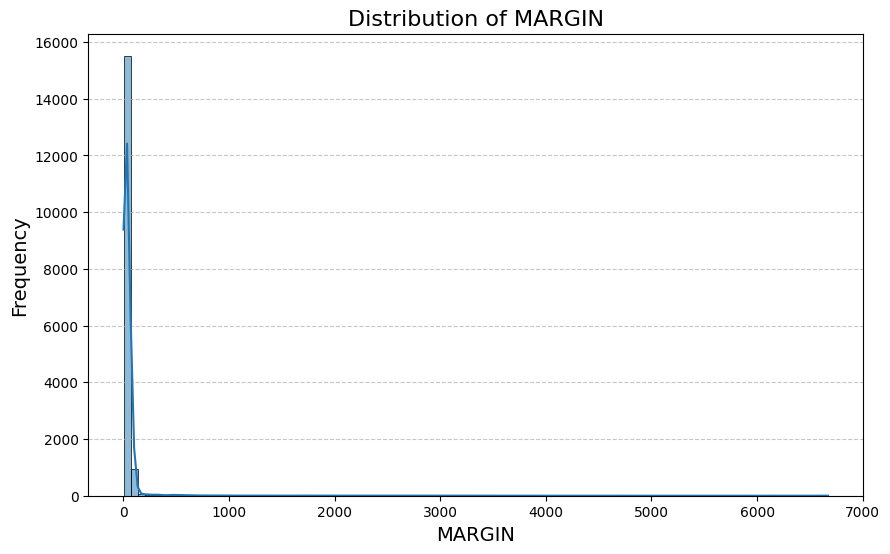

In [11]:
# Plot the distribution of N_TRANSACTIONS
plt.figure(figsize=(10, 6))
sns.histplot(df_train['MARGIN'], kde=True, bins=100)
plt.title("Distribution of MARGIN", fontsize=16)
plt.xlabel("MARGIN", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

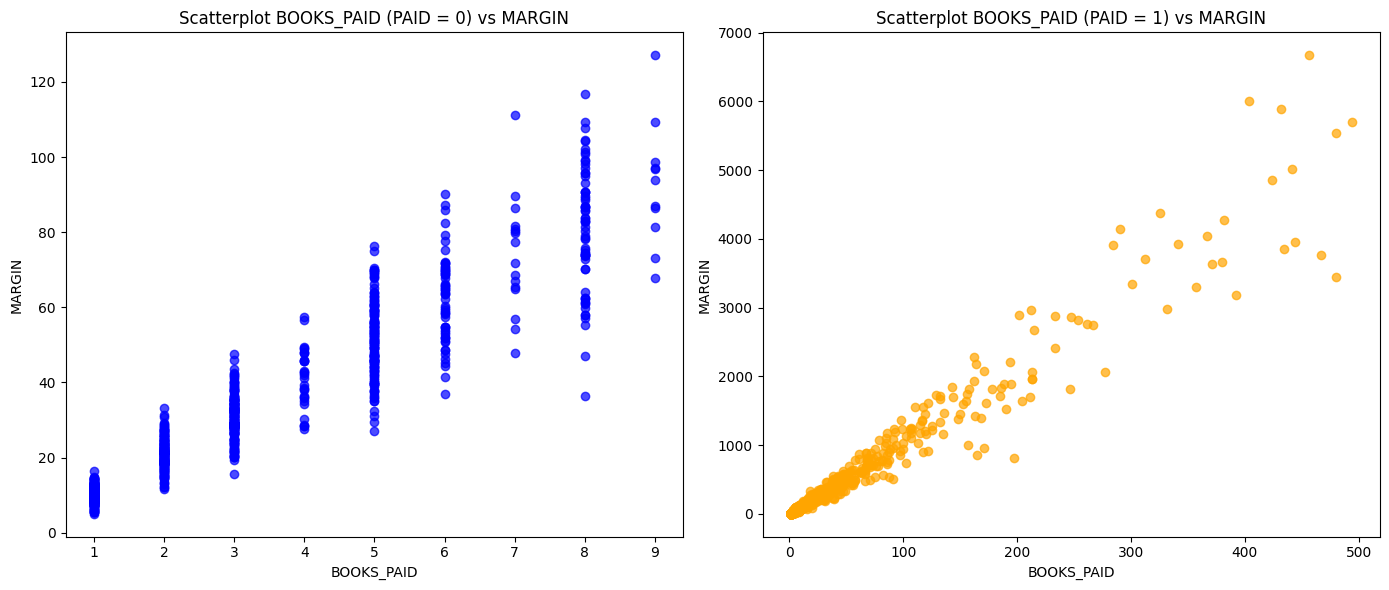

In [12]:
data_paid_0 = df_train[df_train['PAID'] == 0]
data_paid_1 = df_train[df_train['PAID'] == 1]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(data_paid_0['BOOKS_PAID'], data_paid_0['MARGIN'], alpha=0.7, color='blue')
plt.title('Scatterplot BOOKS_PAID (PAID = 0) vs MARGIN')
plt.xlabel('BOOKS_PAID')
plt.ylabel('MARGIN')

plt.subplot(1, 2, 2)
plt.scatter(data_paid_1['BOOKS_PAID'], data_paid_1['MARGIN'], alpha=0.7, color='orange')
plt.title('Scatterplot BOOKS_PAID (PAID = 1) vs MARGIN')
plt.xlabel('BOOKS_PAID')
plt.ylabel('MARGIN')

plt.tight_layout()
plt.show()

Anche in questo caso, seppure in maniera meno evidente sembrerebbe essere in presenza di eteroschedasticità.

Si decide di procedere nell'applicazione di una trasformazone logaritmica, nel tentativo di ripristinare l'omoschedasticità.

In [13]:
df_train['LOG_N_TRANSACTIONS'] = np.log1p(df_train['N_TRANSACTIONS'])  #log(1+x)
df_train['LOG_BOOKS_PAID'] = np.log1p(df_train['BOOKS_PAID'])
df_train['LOG_MARGIN']=np.log1p(df_train['MARGIN'])

Ricostruisco gli scatterplot per MARGIN

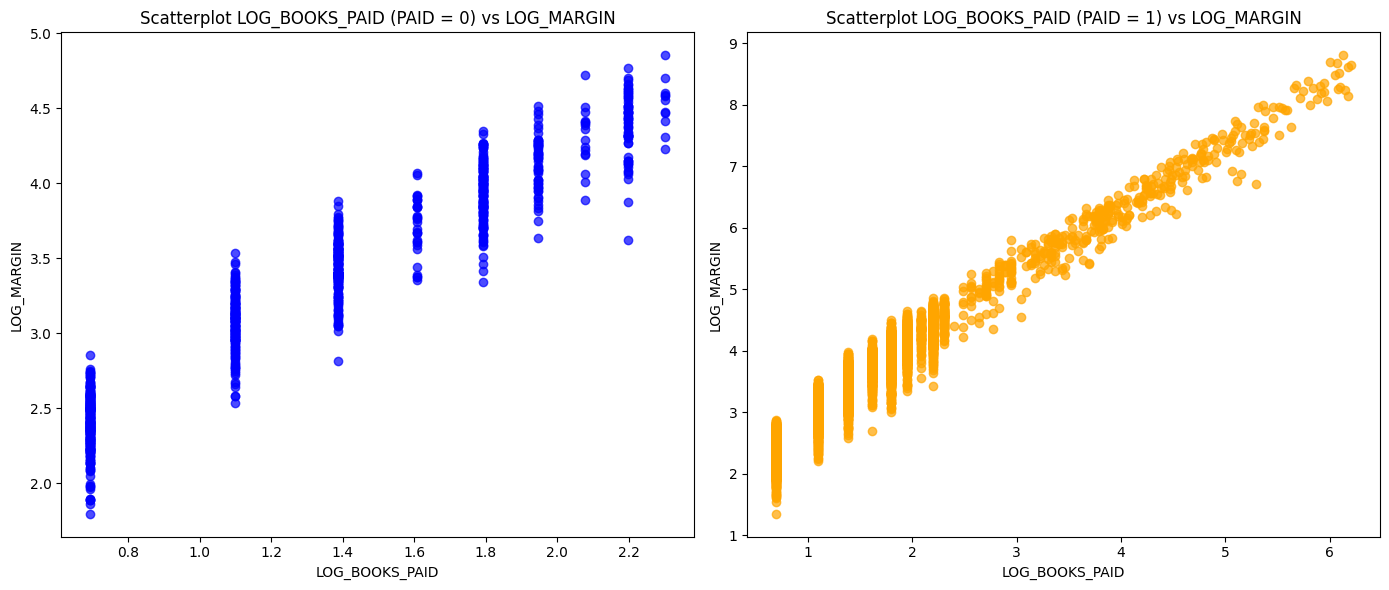

In [14]:
data_paid_0 = df_train[df_train['PAID'] == 0]
data_paid_1 = df_train[df_train['PAID'] == 1]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(data_paid_0['LOG_BOOKS_PAID'], data_paid_0['LOG_MARGIN'], alpha=0.7, color='blue')
plt.title('Scatterplot LOG_BOOKS_PAID (PAID = 0) vs LOG_MARGIN')
plt.xlabel('LOG_BOOKS_PAID')
plt.ylabel('LOG_MARGIN')

plt.subplot(1, 2, 2)
plt.scatter(data_paid_1['LOG_BOOKS_PAID'], data_paid_1['LOG_MARGIN'], alpha=0.7, color='orange')
plt.title('Scatterplot LOG_BOOKS_PAID (PAID = 1) vs LOG_MARGIN')
plt.xlabel('LOG_BOOKS_PAID')
plt.ylabel('LOG_MARGIN')

plt.tight_layout()
plt.show()

Ricostruisco gli scatterplot della variabile N_TRANSACTIONS

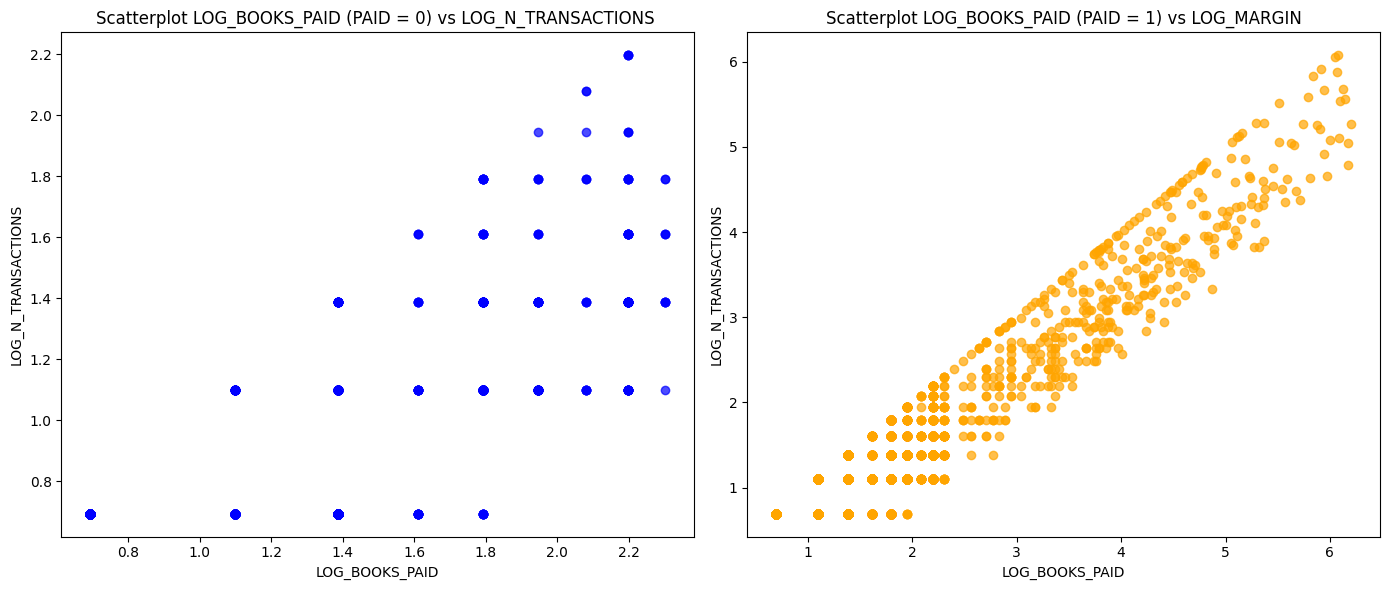

In [15]:
data_paid_0 = df_train[df_train['PAID'] == 0]
data_paid_1 = df_train[df_train['PAID'] == 1]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(data_paid_0['LOG_BOOKS_PAID'], data_paid_0['LOG_N_TRANSACTIONS'], alpha=0.7, color='blue')
plt.title('Scatterplot LOG_BOOKS_PAID (PAID = 0) vs LOG_N_TRANSACTIONS ')
plt.xlabel('LOG_BOOKS_PAID')
plt.ylabel('LOG_N_TRANSACTIONS')

plt.subplot(1, 2, 2)
plt.scatter(data_paid_1['LOG_BOOKS_PAID'], data_paid_1['LOG_N_TRANSACTIONS'], alpha=0.7, color='orange')
plt.title('Scatterplot LOG_BOOKS_PAID (PAID = 1) vs LOG_MARGIN')
plt.xlabel('LOG_BOOKS_PAID')
plt.ylabel('LOG_N_TRANSACTIONS')

plt.tight_layout()
plt.show()

La trasformazione sembrerebbe aver avuto successo.

Sostituisco le variabili trasformate in df_train

In [16]:
df_train['N_TRANSACTIONS'] = df_train['LOG_N_TRANSACTIONS']
df_train['BOOKS_PAID'] = df_train['LOG_BOOKS_PAID']
df_train['MARGIN']=df_train['LOG_MARGIN']

Calcolo della matrice di correlazione per verificare che le variabili siano correlate linearmente:

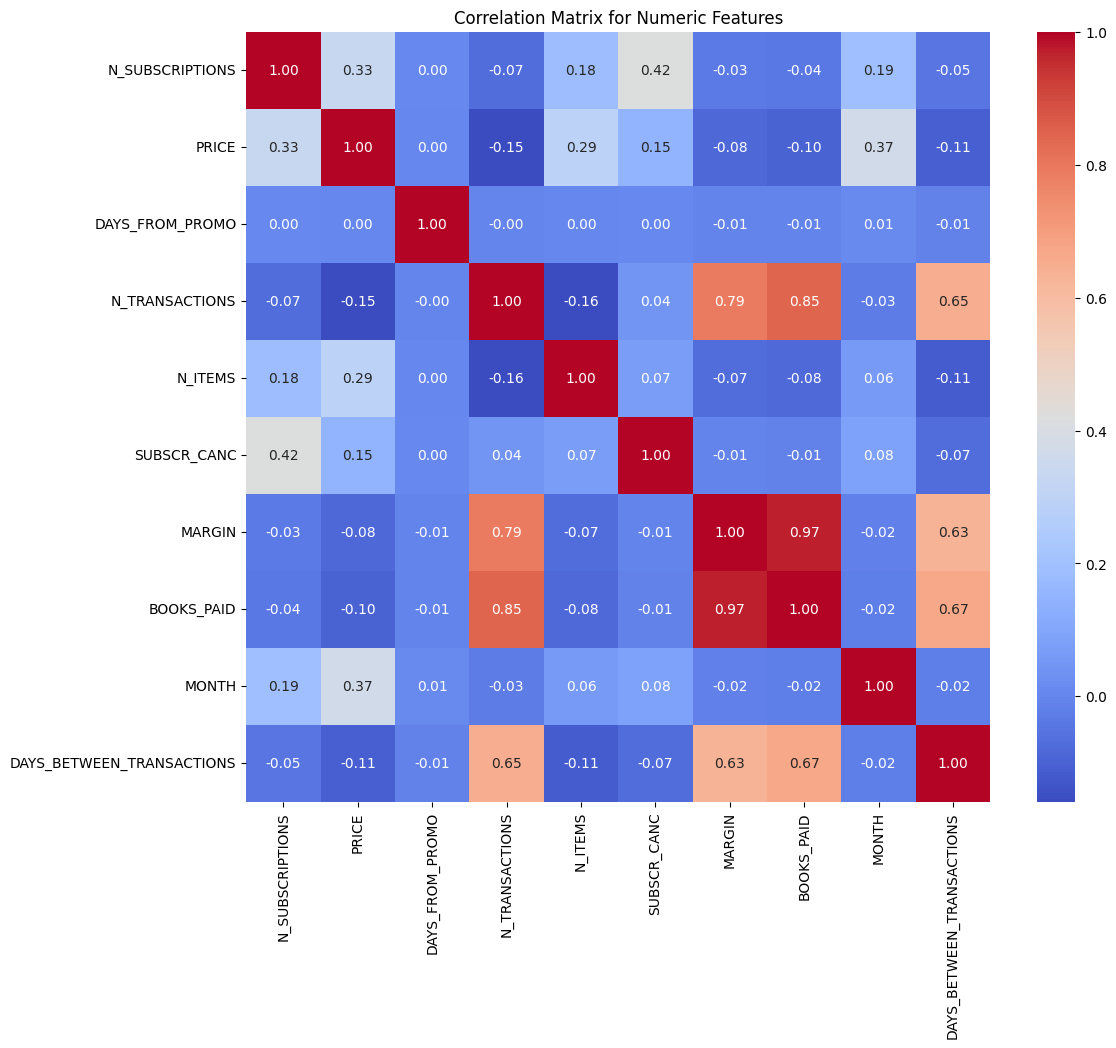

Variabili eliminate perché con correlazione superiore a 0.9: {'BOOKS_PAID'}
Variabili rimaste: ['N_SUBSCRIPTIONS', 'PRICE', 'DAYS_FROM_PROMO', 'N_TRANSACTIONS', 'N_ITEMS', 'SUBSCR_CANC', 'MARGIN', 'MONTH', 'DAYS_BETWEEN_TRANSACTIONS']


In [17]:
numeric_features = ['N_SUBSCRIPTIONS', 'PRICE', 'DAYS_FROM_PROMO',
                    'N_TRANSACTIONS', 'N_ITEMS', 'SUBSCR_CANC', 'MARGIN','BOOKS_PAID','MONTH', 'DAYS_BETWEEN_TRANSACTIONS']

X = df_train.drop(columns=['PAID'])
y = df_train['PAID']
X_numeric = X[numeric_features]

corr_matrix = X_numeric.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix for Numeric Features")
plt.show()

threshold = 0.9
high_corr_pairs = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            colname = corr_matrix.columns[i]
            high_corr_pairs.add(colname)

numeric_features_reduced = [col for col in numeric_features if col not in high_corr_pairs]
print("Variabili eliminate perché con correlazione superiore a 0.9:", high_corr_pairs)
print("Variabili rimaste:", numeric_features_reduced)

Uno sguardo allo scatterplot generale

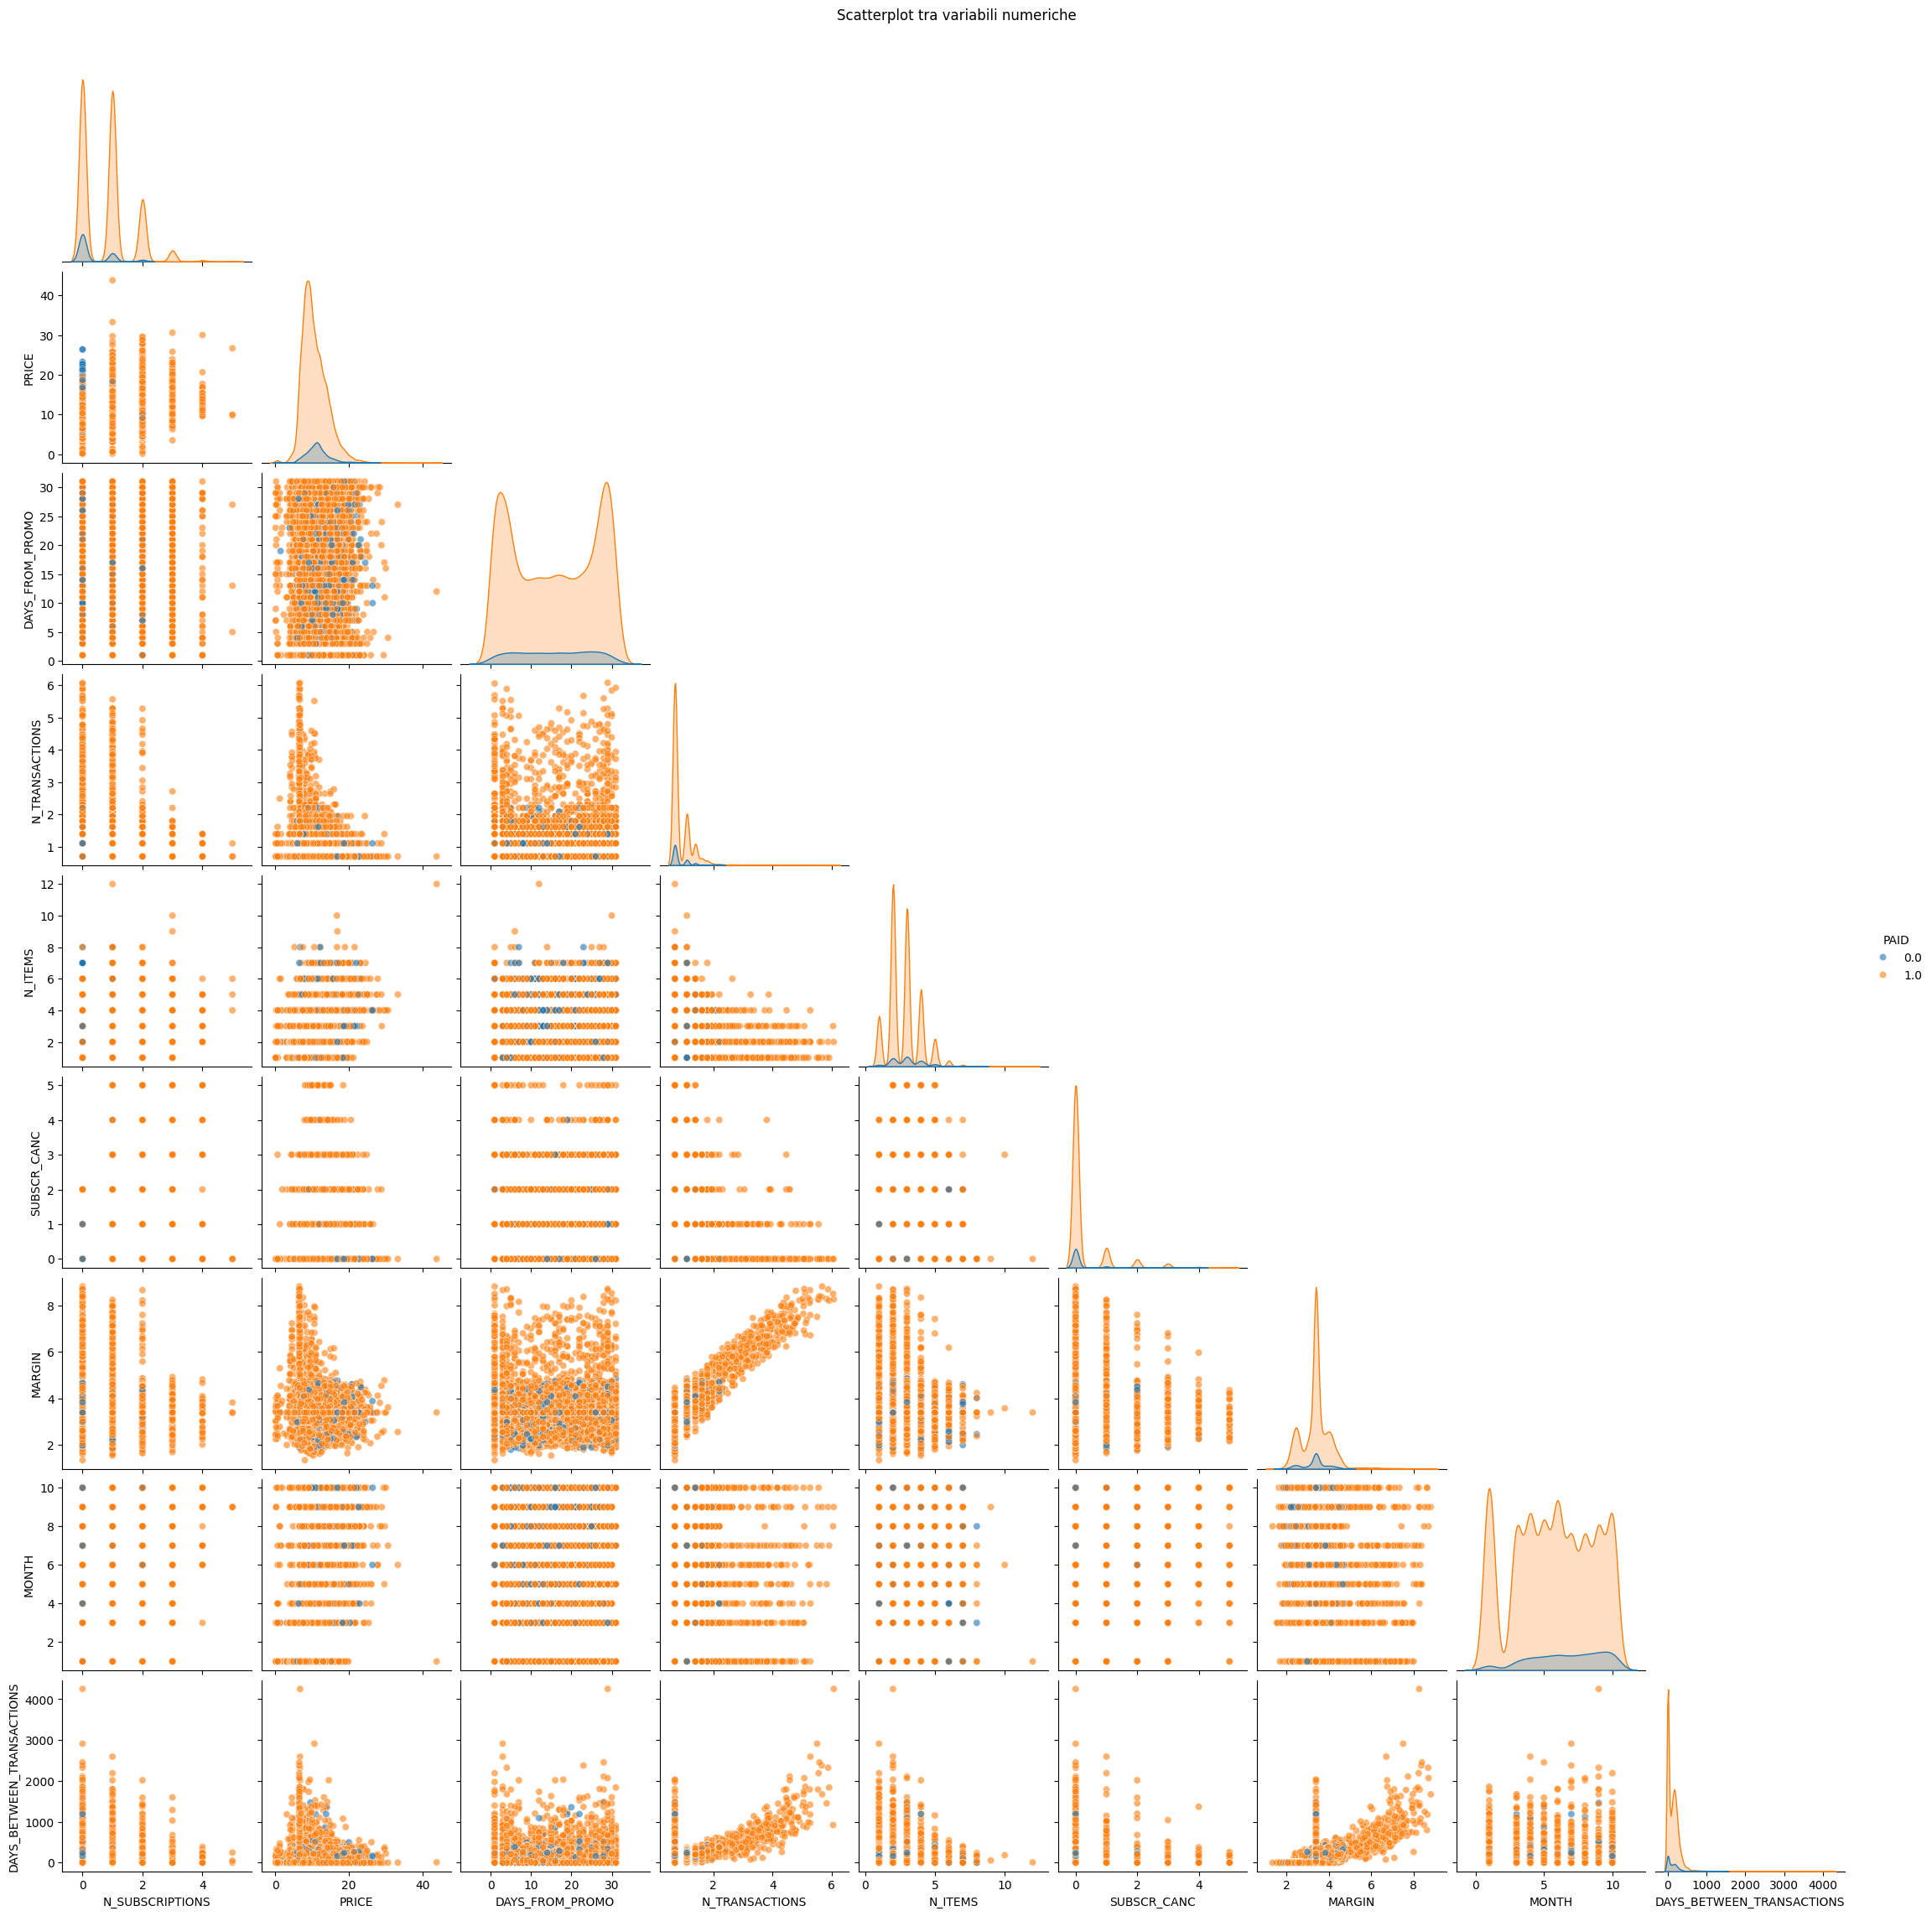

In [27]:
numeric_features = [ 'N_SUBSCRIPTIONS', 'PRICE', 'DAYS_FROM_PROMO', 'N_TRANSACTIONS', 'N_ITEMS', 'SUBSCR_CANC', 'MARGIN', 'MONTH', 'DAYS_BETWEEN_TRANSACTIONS' ]

data_numeric = df_train[numeric_features + ['PAID']]

sns.pairplot(data_numeric, hue='PAID', corner=True, plot_kws={'alpha': 0.6})
plt.suptitle('Scatterplot tra variabili numeriche', y=1.02)
plt.show()

# Analisi descrittiva delle variabili categoriche

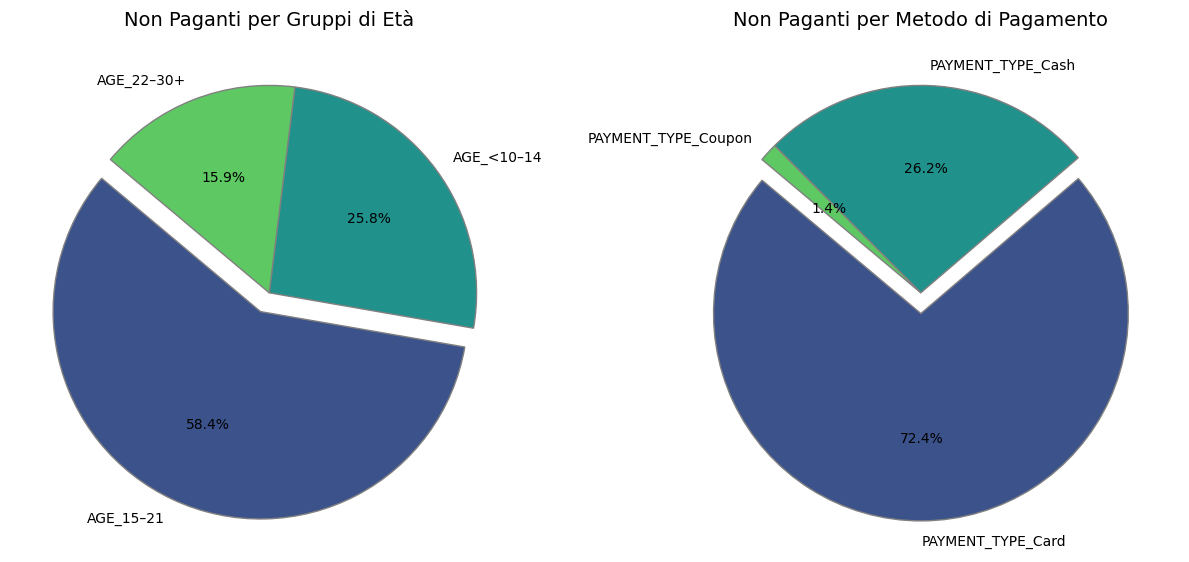

In [28]:
age_columns = ['AGE_<10–14', 'AGE_15–21', 'AGE_22–30+']
payment_columns = ['PAYMENT_TYPE_Card', 'PAYMENT_TYPE_Cash', 'PAYMENT_TYPE_Coupon']

total_non_paying = len(df_train[df_train['PAID'] == 0])

age_non_paying_counts = []
for age_group in age_columns:
    non_paying_count = len(df_train[(df_train[age_group] == True) & (df_train['PAID'] == 0)])
    percentage = (non_paying_count / total_non_paying) * 100 if total_non_paying > 0 else 0
    age_non_paying_counts.append({'GROUP': age_group, 'NON_PAYING_COUNT': non_paying_count, 'PERCENTAGE': percentage})

payment_non_paying_counts = []
for payment_type in payment_columns:
    non_paying_count = len(df_train[(df_train[payment_type] == True) & (df_train['PAID'] == 0)])
    percentage = (non_paying_count / total_non_paying) * 100 if total_non_paying > 0 else 0
    payment_non_paying_counts.append({'GROUP': payment_type, 'NON_PAYING_COUNT': non_paying_count, 'PERCENTAGE': percentage})

age_non_paying_df = pd.DataFrame(age_non_paying_counts).sort_values(by='PERCENTAGE', ascending=False)
payment_non_paying_df = pd.DataFrame(payment_non_paying_counts).sort_values(by='PERCENTAGE', ascending=False)

age_labels = age_non_paying_df['GROUP']
age_sizes = age_non_paying_df['PERCENTAGE']
age_explode = [0.1 if i == max(age_sizes) else 0 for i in age_sizes]
age_colors = sns.color_palette('viridis', len(age_sizes))

payment_labels = payment_non_paying_df['GROUP']
payment_sizes = payment_non_paying_df['PERCENTAGE']
payment_explode = [0.1 if i == max(payment_sizes) else 0 for i in payment_sizes]
payment_colors = sns.color_palette('viridis', len(payment_sizes))

fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=100)

axes[0].pie(
    age_sizes, labels=age_labels, autopct='%1.1f%%', startangle=140, explode=age_explode,
    colors=age_colors, textprops={'fontsize': 10}, wedgeprops={'edgecolor': 'gray'}
)
axes[0].set_title('Non Paganti per Gruppi di Età', fontsize=14)

axes[1].pie(
    payment_sizes, labels=payment_labels, autopct='%1.1f%%', startangle=140, explode=payment_explode,
    colors=payment_colors, textprops={'fontsize': 10}, wedgeprops={'edgecolor': 'gray'}
)
axes[1].set_title('Non Paganti per Metodo di Pagamento', fontsize=14)

plt.tight_layout()
plt.show()


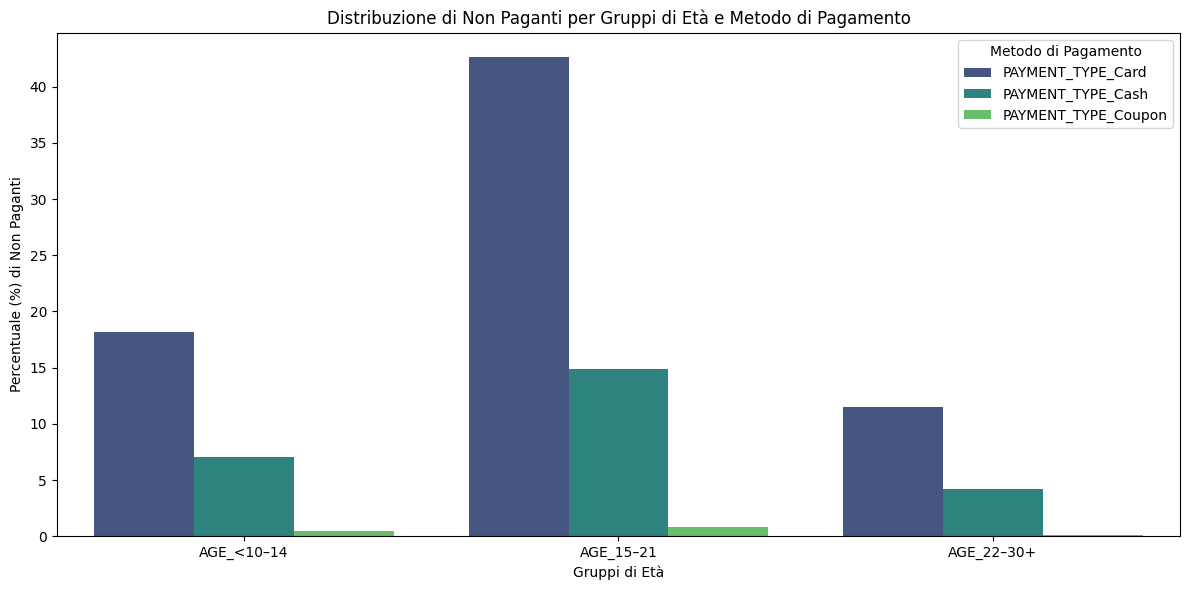

In [29]:
age_columns = ['AGE_<10–14', 'AGE_15–21', 'AGE_22–30+']
payment_columns = ['PAYMENT_TYPE_Card', 'PAYMENT_TYPE_Cash', 'PAYMENT_TYPE_Coupon']

total_non_paying = len(df_train[df_train['PAID'] == 0])

age_payment_counts = []

for age_group in age_columns:
    for payment_type in payment_columns:
        non_paying_count = len(df_train[(df_train[age_group] == True) &
                                        (df_train[payment_type] == True) &
                                        (df_train['PAID'] == 0)])
        percentage = (non_paying_count / total_non_paying) * 100 if total_non_paying > 0 else 0
        age_payment_counts.append({'AGE_GROUP': age_group, 'PAYMENT_TYPE': payment_type,
                                   'NON_PAYING_COUNT': non_paying_count, 'PERCENTAGE': percentage})

age_payment_df = pd.DataFrame(age_payment_counts)

plt.figure(figsize=(12, 6))
sns.barplot(data=age_payment_df, x='AGE_GROUP', y='PERCENTAGE', hue='PAYMENT_TYPE', palette='viridis')
plt.xlabel('Gruppi di Età')
plt.ylabel('Percentuale (%) di Non Paganti')
plt.title('Distribuzione di Non Paganti per Gruppi di Età e Metodo di Pagamento')
plt.legend(title='Metodo di Pagamento', loc='upper right')
plt.tight_layout()
plt.show()


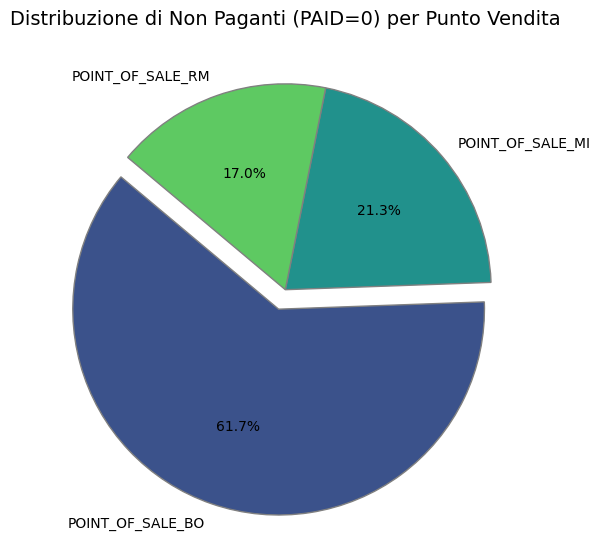

In [30]:
point_of_sale_columns = ['POINT_OF_SALE_BO', 'POINT_OF_SALE_MI', 'POINT_OF_SALE_RM']

total_non_paying = len(df_train[df_train['PAID'] == 0])

pos_non_paying_counts = []

for pos in point_of_sale_columns:
    non_paying_count = len(df_train[(df_train[pos] == True) & (df_train['PAID'] == 0)])
    percentage = (non_paying_count / total_non_paying) * 100 if total_non_paying > 0 else 0
    pos_non_paying_counts.append({'POINT_OF_SALE': pos, 'NON_PAYING_COUNT': non_paying_count, 'PERCENTAGE': percentage})

pos_non_paying_df = pd.DataFrame(pos_non_paying_counts)

pos_non_paying_df = pos_non_paying_df.sort_values(by='PERCENTAGE', ascending=False)

labels = pos_non_paying_df['POINT_OF_SALE']
sizes = pos_non_paying_df['PERCENTAGE']
explode = [0.1 if i == max(sizes) else 0 for i in sizes]
colors = sns.color_palette('viridis', len(sizes))

plt.figure(figsize=(6, 6), dpi=100)
plt.pie(
    sizes, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode,
    colors=colors, textprops={'fontsize': 10}, wedgeprops={'edgecolor': 'gray'}
)

plt.title('Distribuzione di Non Paganti (PAID=0) per Punto Vendita', fontsize=14)
plt.tight_layout()
plt.show()


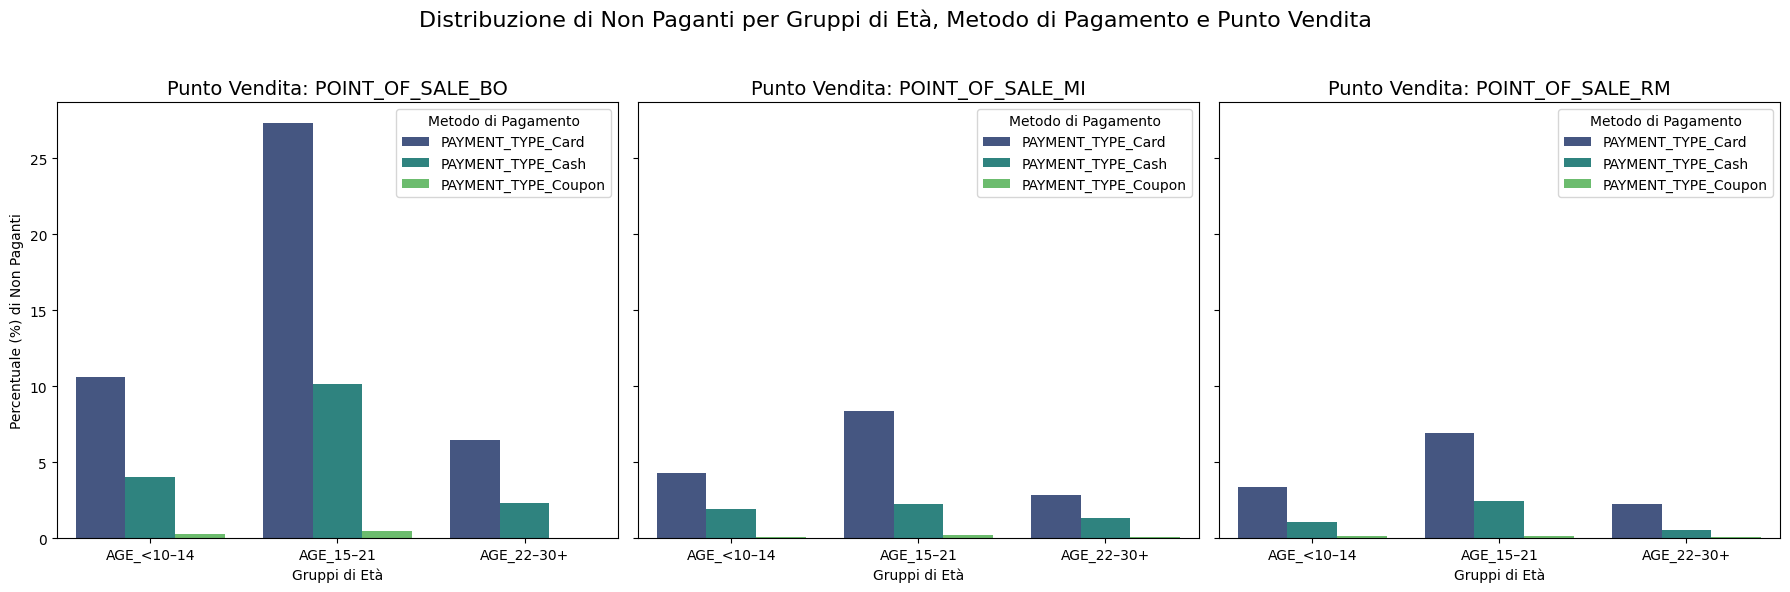

In [23]:
age_columns = ['AGE_<10–14', 'AGE_15–21', 'AGE_22–30+']
payment_columns = ['PAYMENT_TYPE_Card', 'PAYMENT_TYPE_Cash', 'PAYMENT_TYPE_Coupon']
point_of_sale_columns = ['POINT_OF_SALE_BO', 'POINT_OF_SALE_MI', 'POINT_OF_SALE_RM']

total_non_paying = len(df_train[df_train['PAID'] == 0])

age_payment_pos_counts = []

for age_group in age_columns:
    for payment_type in payment_columns:
        for point_of_sale in point_of_sale_columns:
            non_paying_count = len(df_train[(df_train[age_group] == True) &
                                            (df_train[payment_type] == True) &
                                            (df_train[point_of_sale] == True) &
                                            (df_train['PAID'] == 0)])
            percentage = (non_paying_count / total_non_paying) * 100 if total_non_paying > 0 else 0
            age_payment_pos_counts.append({'AGE_GROUP': age_group,
                                           'PAYMENT_TYPE': payment_type,
                                           'POINT_OF_SALE': point_of_sale,
                                           'NON_PAYING_COUNT': non_paying_count,
                                           'PERCENTAGE': percentage})

age_payment_pos_df = pd.DataFrame(age_payment_pos_counts)

fig, axes = plt.subplots(1, len(point_of_sale_columns), figsize=(18, 6), sharey=True)

for i, point_of_sale in enumerate(point_of_sale_columns):

    subset = age_payment_pos_df[age_payment_pos_df['POINT_OF_SALE'] == point_of_sale]


    sns.barplot(
        data=subset, x='AGE_GROUP', y='PERCENTAGE', hue='PAYMENT_TYPE',
        palette='viridis', ax=axes[i]
    )
    axes[i].set_title(f'Punto Vendita: {point_of_sale}', fontsize=14)
    axes[i].set_xlabel('Gruppi di Età')
    axes[i].set_ylabel('Percentuale (%) di Non Paganti' if i == 0 else "")
    axes[i].legend(title='Metodo di Pagamento', loc='upper right')

plt.suptitle('Distribuzione di Non Paganti per Gruppi di Età, Metodo di Pagamento e Punto Vendita', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Elimino le colonne precedentemente utilizzate:

In [24]:
df_train = df_train.drop(columns=['HAS_PHONE', 'HAS_EMAIL'])

In [25]:
X = df_train.drop(columns=['PAID'])
y = df_train['PAID']

Test del chi quadrato per le variabili categoriche

In [32]:
binary_features = [col for col in X.columns if (X[col].nunique() == 2)]

chi_scores, p_values = chi2(df_train[binary_features], df_train['PAID'])

chi2_results = pd.DataFrame({
    'Feature': binary_features,
    'Chi2_Score': chi_scores,
    'P_Value': p_values
}).sort_values(by='P_Value', ascending=True)

print("Risultati del test chi-quadrato per feature binarie:")
print(chi2_results)

relevant_binary = chi2_results[chi2_results['P_Value'] < 0.05]['Feature']
print("Feature binarie rilevanti:", relevant_binary.tolist())

Risultati del test chi-quadrato per feature binarie:
                Feature  Chi2_Score       P_Value
7   PAYMENT_TYPE_Coupon   74.234639  6.936246e-18
3      POINT_OF_SALE_MI   62.135835  3.205646e-15
0          PHONE_NUMBER   42.280976  7.905787e-11
1                  MAIL   34.585079  4.080219e-09
12           AGE_22–30+   23.533989  1.227265e-06
15   PROP_CONBINI_Medio   23.257034  1.417311e-06
2      POINT_OF_SALE_BO   16.711354  4.351976e-05
11            AGE_15–21   14.878742  1.146477e-04
13    PROP_CONBINI_Alto   12.981635  3.145611e-04
5     PAYMENT_TYPE_Card   12.222314  4.722133e-04
14   PROP_CONBINI_Basso    1.689252  1.936996e-01
4      POINT_OF_SALE_RM    1.488348  2.224730e-01
8       FAV_GENRE_Shojo    1.035273  3.089234e-01
10           AGE_<10–14    0.989461  3.198741e-01
6     PAYMENT_TYPE_Cash    0.928035  3.353740e-01
9      FAV_GENRE_Shonen    0.203348  6.520319e-01
Feature binarie rilevanti: ['PAYMENT_TYPE_Coupon', 'POINT_OF_SALE_MI', 'PHONE_NUMBER', 'MAIL', 'A

 Combino le feature numeriche rimaste e le binarie rilevanti

In [33]:
selected_features = numeric_features_reduced + list(relevant_binary)

X_reduced = df_train[selected_features]

print("Feature selezionate:", selected_features)

Feature selezionate: ['N_SUBSCRIPTIONS', 'PRICE', 'DAYS_FROM_PROMO', 'N_TRANSACTIONS', 'N_ITEMS', 'SUBSCR_CANC', 'MARGIN', 'MONTH', 'DAYS_BETWEEN_TRANSACTIONS', 'PAYMENT_TYPE_Coupon', 'POINT_OF_SALE_MI', 'PHONE_NUMBER', 'MAIL', 'AGE_22–30+', 'PROP_CONBINI_Medio', 'POINT_OF_SALE_BO', 'AGE_15–21', 'PROP_CONBINI_Alto', 'PAYMENT_TYPE_Card']


In [34]:
selected_features.append('PAID')
selected_features

['N_SUBSCRIPTIONS',
 'PRICE',
 'DAYS_FROM_PROMO',
 'N_TRANSACTIONS',
 'N_ITEMS',
 'SUBSCR_CANC',
 'MARGIN',
 'MONTH',
 'DAYS_BETWEEN_TRANSACTIONS',
 'PAYMENT_TYPE_Coupon',
 'POINT_OF_SALE_MI',
 'PHONE_NUMBER',
 'MAIL',
 'AGE_22–30+',
 'PROP_CONBINI_Medio',
 'POINT_OF_SALE_BO',
 'AGE_15–21',
 'PROP_CONBINI_Alto',
 'PAYMENT_TYPE_Card',
 'PAID']

In [35]:
df_train=df_train[selected_features]

In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16842 entries, 0 to 16841
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   N_SUBSCRIPTIONS            16842 non-null  int64  
 1   PRICE                      16842 non-null  float64
 2   DAYS_FROM_PROMO            16842 non-null  int64  
 3   N_TRANSACTIONS             16842 non-null  float64
 4   N_ITEMS                    16842 non-null  int64  
 5   SUBSCR_CANC                16842 non-null  int64  
 6   MARGIN                     16842 non-null  float64
 7   MONTH                      16842 non-null  int64  
 8   DAYS_BETWEEN_TRANSACTIONS  16842 non-null  int64  
 9   PAYMENT_TYPE_Coupon        16842 non-null  bool   
 10  POINT_OF_SALE_MI           16842 non-null  bool   
 11  PHONE_NUMBER               16842 non-null  int64  
 12  MAIL                       16842 non-null  int64  
 13  AGE_22–30+                 16842 non-null  boo

In [38]:
df_train['PAID']=df_train['PAID'].astype(int)

In [39]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16842 entries, 0 to 16841
Data columns (total 20 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   N_SUBSCRIPTIONS            16842 non-null  int64  
 1   PRICE                      16842 non-null  float64
 2   DAYS_FROM_PROMO            16842 non-null  int64  
 3   N_TRANSACTIONS             16842 non-null  float64
 4   N_ITEMS                    16842 non-null  int64  
 5   SUBSCR_CANC                16842 non-null  int64  
 6   MARGIN                     16842 non-null  float64
 7   MONTH                      16842 non-null  int64  
 8   DAYS_BETWEEN_TRANSACTIONS  16842 non-null  int64  
 9   PAYMENT_TYPE_Coupon        16842 non-null  bool   
 10  POINT_OF_SALE_MI           16842 non-null  bool   
 11  PHONE_NUMBER               16842 non-null  int64  
 12  MAIL                       16842 non-null  int64  
 13  AGE_22–30+                 16842 non-null  boo

In [ ]:
df_train.to_csv('processed_df_train_2ndpart.csv', index=False)